<a href="https://colab.research.google.com/github/HopeMoloko/Competitions/blob/master/Fowl_Escapades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'datasets/'

Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
#from fastai.metrics import CrossEntropyFlat
from fastai.basic_train import *
from fastai import *

In [45]:
path = Path(base_dir + 'Birds')
#dest = path
#dest.mkdir(parents=True, exist_ok=True)
path

PosixPath('/content/gdrive/My Drive/datasets/Birds')

In [46]:
Train = pd.read_csv('/content/gdrive/My Drive/datasets/Birds/Train.csv')
Train.head()

,ID,common_name
0,MBMG2C,Ring-necked Dove
1,K8LJSB,Ring-necked Dove
2,OGD9L6,Ring-necked Dove
3,581PCQ,Ring-necked Dove
4,P91M1F,Ring-necked Dove


In [0]:
sub = pd.read_csv('/content/gdrive/My Drive/datasets/Birds/SampleSubmission.csv')
sub.head()

In [48]:
birds = sub.columns[1:]
birds

Index(['Ring-necked Dove', 'Black Cuckoo', 'Red-chested Cuckoo',
       'Fiery-necked Nightjar', 'Green Wood Hoopoe', 'Crested Barbet',
       'Cape Batis', 'Olive Bushshrike', 'Orange-breasted Bushshrike',
       'Bokmakierie', 'Black-backed Puffback', 'Southern Boubou',
       'Black-headed Oriole', 'Fork-tailed Drongo',
       'African Paradise Flycatcher', 'Sabota Lark', 'Eastern Clapper Lark',
       'Rufous-naped Lark', 'Dark-capped Bulbul', 'Sombre Greenbul',
       'Long-billed Crombec', 'African Reed Warbler', 'Rattling Cisticola',
       'Levaillants Cisticola', 'Tawny-flanked Prinia', 'Karoo Prinia',
       'Bar-throated Apalis', 'Green-backed Camaroptera',
       'Chestnut-vented Warbler', 'Cape White-eye', 'Karoo Scrub Robin',
       'White-browed Scrub Robin', 'Cape Robin-Chat',
       'White-browed Robin-Chat', 'Chorister Robin-Chat',
       'Southern Double-collared Sunbird', 'White-bellied Sunbird',
       'African Pipit', 'African Rock Pipit', 'Cape Bunting'],
      d

In [0]:
# Add file names
Train['file_name'] = 'Train/'+Train['ID']+'.mp3'
sub['file_name'] = 'Test/'+sub['ID']+'.mp3'

In [0]:
import IPython.display as ipd
from matplotlib import pyplot as plt
import librosa

In [0]:
#listen to a sound
pth = Train['file_name'].sample(5).values[0]
ipd.Audio('/content/gdrive/My Drive/datasets/Birds/'+pth)

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import numpy as np
import librosa.display

In [0]:
# Creat forlder for generating Audio to Spectrogram using melspectrogram

def create_fold_spectrograms():
    path_dir = '/content/gdrive/My Drive/datasets/Birds/Test'
    spec_dir = Path('/content/gdrive/My Drive/datasets/Birds/Test_spec')

    for audio_file in list(Path(path_dir).ls()) :
      
      name_file = audio_file.as_posix()
      filename  = spec_dir/Path(audio_file).name.replace('.mp3','.png')
  
      if not os.path.isfile(filename):  # Cheeck if the file already exists first in the Train_spec

        samples, sample_rate = librosa.load(audio_file)
        fig = plt.figure(figsize=[0.72,0.72])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        #filename  = spec_dir/Path(audio_file).name.replace('.mp3','.png')
        S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
        plt.close('all')

In [0]:
#create_fold_spectrograms()  # uncomment to generate spectrograms


In [55]:
# Checking that the spectrograms were generated successfully:
import glob
ims = glob.glob(path.as_posix()+'/Train_spec/*.png')
print(len(ims), len(Train))

1857 1857


In [56]:
# Similarly, test now has rows for files that have had spectrograms created.
sub['img_path'] = path.as_posix() + '/Test_spec/' +sub['file_name'].str[:-4]+'.png'
ims = glob.glob(path.as_posix()+'/Test_spec/*.png')
test = sub.loc[sub.img_path.isin(ims)]
print(len(sub), len(ims))

911 911


In [0]:
Train['img_path'] = 'Train_spec' + Train['file_name'].str[5:-4]+'.png'   # New image path coloumn in Test df


In [0]:
Train

In [0]:
# Load data for size 128 ( then change sizes for transfer learning)

data =  ImageDataBunch.from_df(path, df=Train[["img_path", "common_name"]], ds_tfms=[], size=128)\
      .split_by_rand_pct()\
      .label_from_df(cols='common_name')\
      .databunch()\
      .normalize(imagenet_stats)


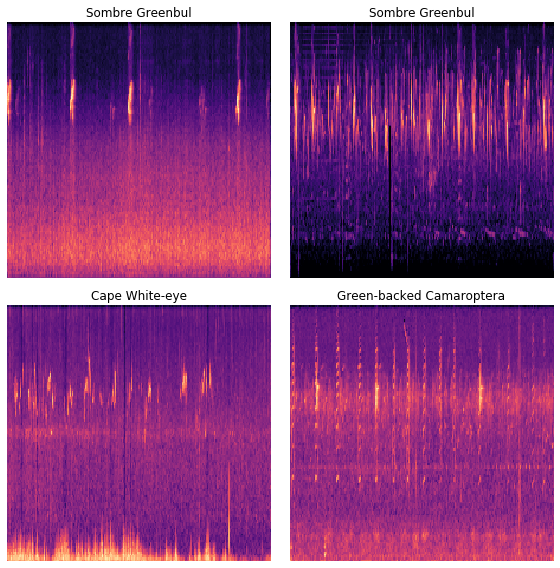

In [63]:
data.show_batch(rows=2)

In [0]:
arch = models.resnet50   #Architecture Model (Try resnet18 and 34 first)

In [0]:
learn = cnn_learner(data, arch, metrics=[error_rate,accuracy])  # Create you cnn with defined architecture and check accuray or error rate

In [0]:
learn.freeze()     #Freeze whole model except the last layers which injected to cater for your data (Tranfer learning)

In [0]:
 learn.lr_find()   # Look for best learning rate
 learn.recorder.plot()

In [67]:
lr = 1e-02
learn.fit_one_cycle(6 , lr)   # Fit only the new layers

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,4.804782,3.829318,0.808081,0.191919,00:20
1,3.684110,3.715652,0.757576,0.242424,00:20
2,3.076694,3.337424,0.723906,0.276094,00:20
3,2.469293,2.831885,0.659933,0.340067,00:20
4,1.841116,2.395749,0.569024,0.430976,00:20
5,1.372378,2.349501,0.565657,0.434343,00:20


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


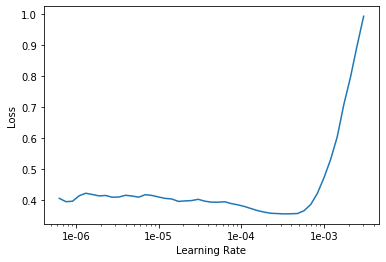

In [68]:
learn.unfreeze()       # Unfreeze the whole model ( all the layers and look for good lr)
learn.lr_find()
learn.recorder.plot()

In [69]:
learn.fit_one_cycle(7, slice(1e-05,1e-04))   # Train the whole model using discriminate learning rates

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.394602,2.324072,0.558923,0.441077,00:26
1,0.336384,2.286963,0.548822,0.451178,00:26
2,0.262579,2.305418,0.545455,0.454545,00:26
3,0.203836,2.271573,0.528620,0.471380,00:27
4,0.162863,2.244914,0.538721,0.461279,00:27
5,0.131088,2.247344,0.531987,0.468013,00:26
6,0.107613,2.239950,0.535354,0.464646,00:26


In [0]:
learn.save('stage-2-128_rsn50')    # Save params

# Train with 223 now

In [0]:
data_new =  (ImageDataBunch.from_df(path, df=Train[["img_path", "common_name"]], ds_tfms=[], size=223)  # Now change size and do same thing
      .split_by_rand_pct()
      .label_from_df(cols='common_name')
      .databunch()
      .normalize(imagenet_stats))


In [0]:
learn.data = data_new   # Don forget to give the cnn the new data

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


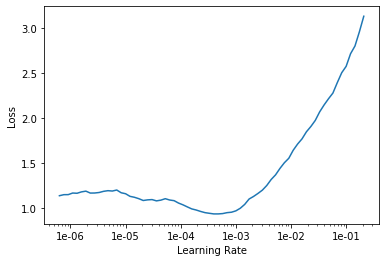

In [28]:
learn.recorder.plot()

In [0]:
learn.unfreeze()

In [74]:
learn.fit_one_cycle(10, slice(1e-05 , 1e-04))  # Train the whole model

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.076638,0.802038,0.178451,0.821549,00:26
1,0.940839,0.793647,0.181818,0.818182,00:27
2,0.732919,0.763166,0.175084,0.824916,00:26
3,0.532354,0.760192,0.168350,0.831650,00:26
4,0.383051,0.772383,0.178451,0.821549,00:26
5,0.283724,0.772862,0.181818,0.818182,00:26
6,0.211777,0.782654,0.175084,0.824916,00:26
7,0.161289,0.781813,0.175084,0.824916,00:26
8,0.126245,0.775851,0.175084,0.824916,00:27
9,0.101922,0.776899,0.175084,0.824916,00:27


In [0]:
learn.save('stage-2-223-rsn50')   # Save params

 # 

In [0]:
Test['img_path'] = 'Test_spec/' +sub['file_name'].str[5:-4]+'.png'  # Add image path to test

In [0]:
learn.export('birds_rsn50_v6.pkl')  #Export saved params of your cnn model

# Predictions

In [0]:
data_test = (ImageList.from_df(df = Test, path = path,  cols='img_path'))   # Use test data

In [81]:
learn = load_learner(path,'birds_rsn50_v6.pkl', test=data_test)   # load saved params
preds, _ = learn.get_preds(ds_type=DatasetType.Test)              # make predictions


In [0]:
fnames = [f[50:-4] for f in learn.data.test_ds.items]      # get each test image file name (ID)
labelled_preds = [list(pred) for pred in preds]            # LABEls FOR EACH id

In [0]:
# Delete some useless columns ( There a clever ways)
del sub['file_name']                           
del sub['img_path']

In [0]:
sub['ID'] = fnames      # Add IDS

In [0]:
for b in birds:
    sub[b] = preds[:,learn.data.classes.index(b)]    # Add predictions to correspong class

In [0]:
sub

In [88]:
sub.to_csv(path/'submission_birds_5.csv', index=False)    # save file to submitt
print(sub.head())

       ID  Ring-necked Dove  ...  African Rock Pipit  Cape Bunting
0  019OYB          0.000039  ...            0.000002  2.656058e-06
1  01S9OX          0.000148  ...            0.483603  1.305323e-03
2  02CS12          0.006084  ...            0.000462  3.406394e-03
3  02LM3W          0.000146  ...            0.000002  8.304524e-07
4  0C3A2V          0.000064  ...            0.000375  1.185284e-04

[5 rows x 41 columns]
